# Interactive Simulation
This notebook demonstrates how to do an interactive session in NeuroDevSim.  First the general principles are demonstrated and then an example is shown of how to use this to investigate problems in a stored simulation:
- simple demonstration: [Interactive_Random_model](#Random_model)
- debugging an existing simulation: [Import_simulation](#Import_simulation)

## Interactive Random_model
This replicates the behavior of the code that extends a growing branch interactively. Refer to the **Getting Started** section of the **Beginner's Tutorial** in the documentation for an explanation of this code.  

**The output of this part of the notebook has been cleared**: it is the intention that users run each code segment as if  entering the instructions themselves.  

First run the code below. This sets up the basic interactive environment. Notice some important differences with standard model code:
- the ``manage_front`` method does not do anything. This is because its behavior will be replicated interactively. Note that this is not a requirement, a normal ``manage_front`` method can be defined but it will not be called.
- ``Admin_agent`` is set up with zero processing cores to enable interative mode, no file name is needed in this mode because nothing is saved. Plotting is active, but not used yet. 
- The ``Constellation`` is accessed as *admin.constellation*.

In [ ]:
%matplotlib notebook

from neurodevsim.simulator import *

class RandomFront(Front):
    
    def manage_front(self,constellation):
        pass

if __name__ == '__main__':

    # initialize Admin_agent
    sim_volume = [[-100., -100., -100.], [100.0,100.0,100.0]]
    neuron_types = [RandomFront]
    admin = Admin_agent(0,"",sim_volume,neuron_types,verbose=0,plot=True) # no computing, one processor suffices
    constellation = admin.constellation

This created an empty plot. Now create the soma using ``add_neurons``.  
Different from standard use, capture the return of ``add_neurons`` (a list of fronts) so that it can be used  later.

In [ ]:
fronts = admin.add_neurons(RandomFront,"rand_neuron",1,[[-30.,0.,0.],[-30,0.,0.]],5.)
soma = fronts[0]
print (soma) # not necessary, shows that something happened

Note that the soma only exists in this notebook, it has not been stored in the database and there is no way to store to a file interactively.   

But it can be plotted ('k' stands for black):

In [ ]:
line = admin.plot_item(soma,color='k')

Note that the soma appeared in the plot above, plotting will continue in this plot.  
  
Now add the first front of a growing branch by using the code that normally would be part of ``manage_front``. Also plot it:

In [ ]:
new_pos = soma.end + Point(10.,0.,0.) +  unit_sample_on_sphere() * 3.0
front = soma.add_child(admin.constellation,new_pos,radius=1.)
line = admin.plot_item(front)

The first branch segment is now drawn in red. Because no calls to ``manage_front`` happen there is no need to ``disable`` the soma.  

Continue adding fronts in a loop till the end of the simulation volume is reached:

In [ ]:
while front.path_length < 100.:
    new_pos = front.end + Point(10.,0.,0.) +  unit_sample_on_sphere() * 3.0
    front = front.add_child(constellation,new_pos,radius=1.)
    line = admin.plot_item(front)

Note that the consecutive fronts created were not stored. To access those at a later time, use either ``soma.get_children(constellation)`` or ``front.get_parent(constellation)`` to get the relevant object.  
  
This completes the simple demonstration of interactive mode. 

## Import_simulation

Import a simulation to debug the model: try to understand why it did not exhibit expected behaviors.  
  
To do so effectively additional information is needed, in particular the ``ID`` of the fronts that misbehaved. These can be obtained in two ways:
- print out front IDs and relevant activities during the simulation
- analyze the database to get this information, use one of the many SQLite database browser apps available

### Debugging tufted dendrite code
This example investigates why tufted dendrites seem to be much more curly than basal dendrites in this version of the L5 pyramidal neuron model, despite both using ``self.unit_heading_sample(width=20.)``. The effect is quite noticeable in this particular simulation:

<div>
<img src="images/L5_neuron.png" width="240"/>
</div>

This may be due to the other directions added to the one given by ``self.unit_heading_sample(width=20.)``, but which one?

Loading a fairly large simulation (>1000 fronts) and plot it completely can be quite slow. Therefore the *box* optional parameter is used to zoom in on the tufted dendrite only: nothing else is plotted and this goes much faster. To get an isometrical plot, which is easier to interpret, ax regions defined in the *box* for each dimension should be equal. And it also helps to manipulate *azim* and *elev* to get a good view of a problem area and cylindrical fronts are drawn thicker with *radius_scale* to make them better visible.

Run the code below. Only the part of the original code needed to understand the example has been reproduced.

<IPython.core.display.Javascript object>


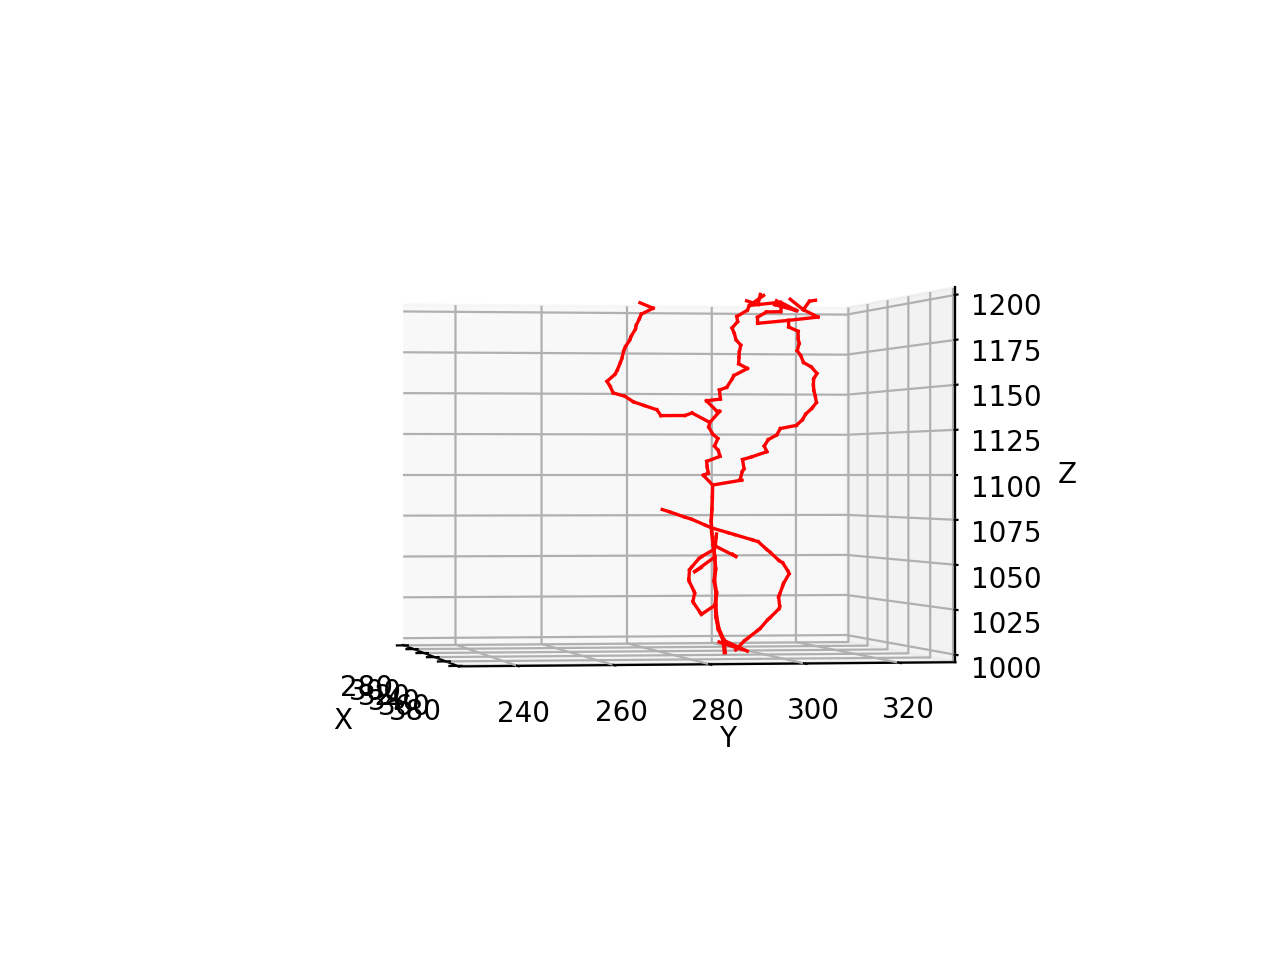

In [7]:
%matplotlib notebook

from neurodevsim.simulator import *
import numpy as np
import random

pia = 1420 # z location of the pia attraction plane
Pia_dir = Point(0.,0.,1.)
No_dir = Point(0.,0.,0.)

# Define the growth processes for the simulation
#  Make a new class for this simulation derived from Front
class L5PyramidalFront(Front):
    _fields_ = Front._fields_ + [('layer',c_short), ('start_order_L3',c_short), \
                                 ('start_order_L2',c_short), ('root_length',c_double)]
    # layer: encodes which cortical layer the front belongs to
    # start_order_L3: order when apical branch entered layer 3
    # start_order_L2: order when apical or tuft branch entered layer 2
    # root_length: path_length at root of oblique dendrite
    # status1: encodes no_branching condition
    
    # returns layer the front is in
    def get_layer(self):
        if self.end.z < 471:
            return 6
        elif self.end.z < 826:
            return 5
        elif self.end.z < 1090:
            return 4
        elif self.end.z < 1192:
            return 3
        elif self.end.z < 1311:
            return 2
        else:
            return 1

    def manage_front(self,constellation):
        if self.order == 0: # this is the soma
            self.create_apical_branch(constellation)
            self.create_basal_branches(constellation)
            self.disable(constellation) # make soma inactive
        elif self.swc_type == 3: # basal dendrite
            if constellation.cycle <= np.random.randint(27,40):
                self.extend_basal_front(constellation)
            else:
                self.disable(constellation) # stop growing
        elif self.swc_type == 4: # apical dendrite
            if constellation.cycle <= 1000:
                if self.num_children == 0: # extend
                    self.extend_apical_front(constellation)
                else: # maybe make oblique dendrite
                    self.create_oblique_branch(constellation)
            else:
                self.disable(constellation) # stop growing
        elif self.swc_type == 8: # oblique dendrite
            self.extend_oblique_front(constellation)
        elif self.swc_type == 9: # oblique dendrite
            self.extend_tuft_front(constellation)
        else:
            print ("ERROR: unknown swc_type",self.swc_type)
            
    def extend_tuft_front(self,constellation):
        # layer specific probability to terminate and compute bifurcation probability
        if self.layer == 3: 
            if (np.random.random() < 0.01) and (self.order - self.start_order_L3 >= 3):
                self.disable(constellation) # stop growing
                return
            bif_prob = 0.1
            if self.order - self.start_order_L3 >= 3:
                bif_prob = 0.
            eigen_repulse = 2.0 + 2.0 * np.random.random()
            pia_repulse = 3.5
        elif self.layer == 2: 
            if np.random.random() < 0.03:
                self.disable(constellation) # stop growing
                return
            bif_prob = 0.08
            if self.order - self.start_order_L3 <= 2:
                bif_prob = 0.4
            elif self.order - self.start_order_L2 >= (3 + 2 * np.random.random()):
                bif_prob = 0.
            eigen_repulse = 0.5 + np.random.random()
            pia_repulse = 2.8
        else: # layer 1
            if np.random.random() < 0.06:
                self.disable(constellation) # stop growing
                return
            if self.is_status1(): # no_branching
                bif_prob = 0.
            else:
                bif_prob = 0.08
                if self.order - self.start_order_L3 <= 4:
                    bif_prob = 0.3
            eigen_repulse = np.random.random()
            pia_repulse = 2.1

        if np.random.random() >= bif_prob: # simply extend
            #  compute direction vectors
            #    repulsed by other fronts from same neuron
            eigen_fronts = self.get_fronts(constellation,what="self",max_distance=25.)
            #    compute repulsion, exponentially decaying over distance for nearest fronts
            if eigen_fronts:
                eigen_strength = eigen_repulse * np.exp(-0.015 * eigen_fronts[0][1]) / eigen_fronts[0][1]
                if eigen_strength < 0.2:
                    eigen_dir = No_dir # no repulsion
                else:
                    eigen_dir = (eigen_fronts[0][0].end - self.end).norm() * eigen_strength
            else:
                eigen_dir = No_dir # no repulsion
            #   attracted by pia
            pia_distance = pia - self.end.z
            pia_strength = pia_repulse * np.exp(-0.015 * pia_distance) / pia_distance
            if pia_strength < 0.2:
                pia_rep = No_dir # no repulsion
            else:
                pia_rep = (Point(self.end.x,self.end.y,pia) - self.end).norm() * pia_strength
            count = 0
            rad = self.taper(0.98)
            while count < 5:
                heading = self.unit_heading_sample(width=20.) # TODO: find proper width
                new_dir = heading - eigen_dir + Pia_dir * 0.4 - pia_rep
                new_pos = self.orig + new_dir.norm() * 7.
                # check for possible errors, mainly GridCompetitionError
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad)
                    layer = new_front.get_layer()
                    new_front.layer = layer
                    if (self.layer == 4) and (layer == 3):
                        self.start_order_L3 = self.order
                    elif self.layer == 3:
                        new_front.start_order_L3 = self.start_order_L3
                        if layer == 2:
                            new_front.start_order_L2 = self.order
                    else:
                        new_front.start_order_L3 = self.start_order_L3
                        new_front.start_order_L2 = self.start_order_L2
                    if self.is_status1():
                        new_front.set_status1() # no_branch
                    self.disable(constellation)
                    return
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
            # did not grow
            if constellation.cycle - self.birth > 2: # mutiple failed attempts
                self.disable(constellation) # stop trying 
        else: # bifurcate
            rnd_dirs = self.unit_branching_sample(8) # generate more points than needed
            rad = self.taper(0.98)
            num_dendr = 0 # number of dendrites made
            for p in rnd_dirs: # make 2 branches
                new_pos = self.end + p * 7.
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad)
                    layer = new_front.get_layer()
                    new_front.layer = layer
                    if self.layer == 3:
                        new_front.start_order_L3 = self.start_order_L3
                        if layer == 2:
                            new_front.start_order_L2 = self.order
                    else:
                        new_front.start_order_L3 = self.start_order_L3
                        new_front.start_order_L2 = self.start_order_L2
                        if self.layer == 1: # only one branch point allowed in layer 1
                            new_front.set_status1()
                    num_dendr += 1
                    if num_dendr == 2: # enough dendrites made
                        self.disable(constellation)
                        return # done for this cycle
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    continue # pick another new_pos, no attempt to correct the error
            # did not branch
            if self.num_children > 0: # single child made -> make front inactive
                self.disable(constellation)

# Initialize and run the simulation
if __name__=="__main__":

    # initialize Admin_agent
    sim_volume = [[0., 0., 400.], [500.,500.,1400.]]
    neuron_types = [L5PyramidalFront]
    admin = Admin_agent(0,"",sim_volume,neuron_types,verbose=0,\
                        plot=True,box=[[280.,230.,1000.],[380.,330.,1200.]],azim=-10,elev=0,radius_scale=2.0)
    
    admin.import_simulation("output/L5pyramidal_neuron_old.db")
    constellation = admin.constellation

We will focus on a close to horizontal tuft dendrite in the center of the image. A SQLite database browser was used to identify a down going tuft front with *z* of about 1100 µm in the *L5pyramidal_neuron_old.db* file and one was found with *neuron_id* 1 and *front_id* 8199. 

Now access this front. Note that we need to convert the id from the database (the ``DataID``) into the one used by the simulator (the ``ID``): 

In [8]:
tuftID = constellation.data_to_id(DataID(1,8199))
tuft_front = constellation.front_by_id(tuftID)
print (tuft_front.orig,tuft_front.end)

[331.20, 284.03, 1134.63] [330.53, 278.77, 1134.53]


To make sure we have the righ front, flash it:

In [11]:
admin.flash_front(tuft_front)

The front we're interested in flashed several times to black and back to red, repeat this if you missed it the first time. If this was not the right front another look at the database may help till a good front is found.  
  
The problem was caused by the parent of *tuft_front*, so this is the one we should test:

In [12]:
tuft_parent = tuft_front.get_parent(constellation)
print (tuft_parent)
print ("layer",tuft_parent.get_layer())

Inactive front 8198 (1): [331.51, 285.52, 1136.11] [331.20, 284.03, 1134.63] radius: 0.30 path_length: 482.50 swc: 9 order: 3, parent: 12187 with 1 children, soma 1, made at 73 (1 1722)
layer 3


Now we can ask the question of why a close to horizontal direction was produced by ``new_dir = heading - eigen_dir + Pia_dir * 0.4 - pia_rep``. For the ``get_fronts`` call the *max_cycle* optional parameter should be used to prevent repulsion from fronts born after *tuft_front* was created.

In [13]:
# layer 2 values
eigen_repulse = 0.5 + np.random.random()
pia_repulse = 2.8

eigen_fronts = tuft_parent.get_fronts(constellation,what="self",max_distance=25.,max_cycle=89)
#    compute repulsion, exponentially decaying over distance for nearest fronts
if eigen_fronts:
    print ("repulsed by",eigen_fronts[0][0])
    eigen_strength = eigen_repulse * np.exp(-0.015 * eigen_fronts[0][1]) / eigen_fronts[0][1]
    if eigen_strength < 0.05:
        eigen_dir = No_dir # no repulsion
    else:
        eigen_dir = (eigen_fronts[0][0].end - tuft_parent.end).norm() * eigen_strength
else:
    eigen_dir = No_dir # no repulsion
#   attracted by pia
pia_distance = pia - tuft_parent.end.z
pia_strength = pia_repulse * np.exp(-0.015 * pia_distance) / pia_distance
if pia_strength < 0.2:
    pia_rep = No_dir # no repulsion
else:
    pia_rep = (Point(tuft_parent.end.x,tuft_parent.end.y,pia) - tuft_parent.end).norm() * pia_strength
heading = tuft_parent.unit_heading_sample(width=20.)
new_dir = heading - eigen_dir + Pia_dir * 0.4 - pia_rep
print ("heading",heading)
print ("eigen_dir",eigen_dir)
print ("Pia_dir",Pia_dir)
print ("pia_rep",pia_rep)
print ("new_dir",new_dir)

repulsed by Inactive front 12186 (1): [330.30, 289.70, 1130.63] [329.53, 292.06, 1137.17] radius: 0.30 path_length: 480.38 swc: 9 order: 3, parent: 4191 with 1 children, soma 1, made at 72 (1 1704)
heading [-0.06, -0.40, -0.91]
eigen_dir [-0.02, 0.08, 0.03]
Pia_dir [0.00, 0.00, 1.00]
pia_rep [0.00, 0.00, 0.00]
new_dir [-0.04, -0.48, -0.54]


The conclusion is that *heading* itself is causing the problem, run the code above a few times to confirm.  
Because *tuft_parent* is already close to horizontal, which is not inappropriate for a branch point, *heading* often gives a negative *z* that can only be fully compensated by increasing the effect of Pia_dir. However, doing so all the time will make other fronts too vertical, so it needs instead to be done only if *heading.z* is negative.